In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
#pip install snscrape

In [7]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

In [8]:
# Setting variables to be used below
maxTweets = 10500

# Creating list to append tweet data to
tweets_list = []

# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('(physical distancing OR #physicaldistancing OR #socialdistancing OR social distancing) since:2019-06-01 until:2020-07-31 lang:en').get_items()):
    if i>maxTweets:
        break
    tweets_list.append([tweet.date, tweet.id, tweet.content])

In [34]:
# Creating a dataframe from the tweets list above
tweets_df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet Id', 'Text'])

# Display first 5 entries from dataframe
tweets_df.head()

Datetime             Tweet Id  \
0 2020-07-30 23:58:26+00:00  1288987346705227777   
1 2020-07-30 23:58:23+00:00  1288987334780825600   
2 2020-07-30 23:57:31+00:00  1288987115238219776   
3 2020-07-30 23:56:46+00:00  1288986926469517313   
4 2020-07-30 23:56:38+00:00  1288986892579426304   

                                                Text  
0  https://t.co/qypH6VfqmT\n\nAn excellent articl...  
1  "People will need visual cues to ingrain the b...  
2  @cwebbonline In CA and I vote in person. Plann...  
3  At VA, #IWearaMaskFor #Veterans. We practice p...  
4  @Shawhelp Launch day of a game-changing mobile...

In [35]:
tweets_df.shape

(10501, 3)

In [11]:
from IPython.display import HTML
import base64

# function that takes in a dataframe and creates a text link to  
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [12]:
create_download_link(tweets_df)

## TextBlob for Target variable

In [13]:
from textblob import TextBlob

def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    # set sentiment 
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else: 
        return 'negative'

In [36]:
sentiments_using_textblob = tweets_df.Text.apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiments_using_textblob.value_counts())

Text
positive  5853
neutral   2637
negative  2011

In [37]:
tweets_df['sentiment'] = sentiments_using_textblob
tweets_df.head()

Datetime             Tweet Id  \
0 2020-07-30 23:58:26+00:00  1288987346705227777   
1 2020-07-30 23:58:23+00:00  1288987334780825600   
2 2020-07-30 23:57:31+00:00  1288987115238219776   
3 2020-07-30 23:56:46+00:00  1288986926469517313   
4 2020-07-30 23:56:38+00:00  1288986892579426304   

                                                Text sentiment  
0  https://t.co/qypH6VfqmT\n\nAn excellent articl...  positive  
1  "People will need visual cues to ingrain the b...   neutral  
2  @cwebbonline In CA and I vote in person. Plann...   neutral  
3  At VA, #IWearaMaskFor #Veterans. We practice p...  positive  
4  @Shawhelp Launch day of a game-changing mobile...  negative

# Text Preprocessing

Removing @names

In [38]:
import re
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text
# We are keeping cleaned tweets in a new column called 'tidy_tweets'
tweets_df['tidy_tweets'] = np.vectorize(remove_pattern)(tweets_df['Text'], "@[\w]*: | *RT*")

Removing links

In [39]:
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tidy_tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets_df['tidy_tweets'] = cleaned_tweets

Remove empty text and duplicates

In [40]:
tweets_df = tweets_df[tweets_df['tidy_tweets']!='']
tweets_df = tweets_df.drop_duplicates(subset=['tidy_tweets'], keep=False)
tweets_df = tweets_df.reset_index(drop=True)  # resetting index

Removing Punctuations, Numbers and Special characters

In [41]:
tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


Remove stopwords

In [42]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_set = set(stopwords.words("english"))
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.absolute_tidy_tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))

tweets_df['absolute_tidy_tweets'] = cleaned_tweets

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Tokenization and Lemmatization

In [43]:
from nltk.stem import WordNetLemmatizer
# Tokenization
tokenized_tweet = tweets_df['absolute_tidy_tweets'].apply(lambda x: x.split())
# Finding Lemma for each word
word_lemmatizer = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
#joining words into sentences (from where they came from)
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets_df['absolute_tidy_tweets'] = tokenized_tweet

In [44]:
tweets_df

Datetime             Tweet Id  \
0    2020-07-30 23:58:26+00:00  1288987346705227777   
1    2020-07-30 23:58:23+00:00  1288987334780825600   
2    2020-07-30 23:57:31+00:00  1288987115238219776   
3    2020-07-30 23:56:46+00:00  1288986926469517313   
4    2020-07-30 23:56:38+00:00  1288986892579426304   
...                        ...                  ...   
9383 2020-07-21 18:05:05+00:00  1285636931490119687   
9384 2020-07-21 18:04:56+00:00  1285636896912269315   
9385 2020-07-21 18:04:49+00:00  1285636867195637760   
9386 2020-07-21 18:03:52+00:00  1285636627591766016   
9387 2020-07-21 18:02:54+00:00  1285636384175394818   

                                                   Text sentiment  \
0     https://t.co/qypH6VfqmT\n\nAn excellent articl...  positive   
1     "People will need visual cues to ingrain the b...   neutral   
2     @cwebbonline In CA and I vote in person. Plann...   neutral   
3     At VA, #IWearaMaskFor #Veterans. We practice p...  positive   
4     @Shawhelp Launch day of a game-changing mobile...  negative   
...                                                 ...       ...   
9383  With physical distancing measures in place, ou...  positive   
9384  If the bus is gonna take out the signs on seat...  positive   
9385            @dugilbo We prefer physical distancing.   neutral   
9386  @mqhlay 1. This article is more concerned with...  positive   
9387  We all yearn for normality but the more we mes...  positive   

                                            tidy_tweets  \
0     An excellent article about the important role ...   
1     "People will need visual cues to ingrain the b...   
2     @cwebbonline In CA and I vote in person. Plann...   
3     At VA, #IWearaMaskFor #Veterans. We practice p...   
4     @Shawhelp Launch day of a game-changing mobile...   
...                                                 ...   
9383  With physical distancing measures in place, ou...   
9384  If the bus is gonna take out the signs on seat...   
9385            @dugilbo We prefer physical distancing.   
9386  @mqhlay 1. This article is more concerned with...   
9387  We all yearn for normality but the more we mes...   

                                   absolute_tidy_tweets  
0     An excellent article important role aerosol tr...  
1     People need visual cue ingrain behavioral chan...  
2     cwebbonline In CA I vote person Planning votin...  
3     At VA We practice physical distancing wash han...  
4     Shawhelp Launch day gamechanging mobile servic...  
...                                                 ...  
9383  With physical distancing measure place service...  
9384  If bus gonna take sign seat say sit physical d...  
9385              dugilbo We prefer physical distancing  
9386  mqhlay This article concerned flouting curfew ...  
9387  We yearn normality mess around longer live lif...  

[9388 rows x 6 columns]

In [45]:
tweets_df.shape

(9388, 6)

## Key Phrases

In [23]:
class PhraseExtractHelper(object):
    def __init__(self):
        self.lemmatizer = nltk.WordNetLemmatizer()
        self.stemmer = nltk.stem.porter.PorterStemmer()
    
    def leaves(self, tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()

    def normalise(self, word):
        """Normalises words to lowercase and stems and lemmatizes it."""
        word = word.lower()
        # word = self.stemmer.stem_word(word) # We will loose the exact meaning of the word 
        word = self.lemmatizer.lemmatize(word)
        return word

    def acceptable_word(self, word):
        """Checks conditions for acceptable word: length, stopword. We can increase the length if we want to consider large phrase"""
        accepted = bool(3 <= len(word) <= 40
            and word.lower() not in stopwords
            and 'https' not in word.lower()
            and 'http' not in word.lower()
            and '#' not in word.lower()
            )
        return accepted

    def get_terms(self, tree):
        for leaf in self.leaves(tree):
            term = [ self.normalise(w) for w,t in leaf if self.acceptable_word(w) ]
            yield term

In [46]:
sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

In [26]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from wordcloud import WordCloud

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [49]:
# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package conll2000 to /usr/share/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading pac

In [29]:
# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

In [50]:
key_phrases = []
phrase_extract_helper = PhraseExtractHelper()

for index, row in tweets_df.iterrows(): 
    toks = nltk.regexp_tokenize(row.tidy_tweets, sentence_re)
    postoks = nltk.tag.pos_tag(toks)
    tree = chunker.parse(postoks)

    terms = phrase_extract_helper.get_terms(tree)
    tweet_phrases = []

    for term in terms:
        if len(term):
            tweet_phrases.append(' '.join(term))
    
    key_phrases.append(tweet_phrases)
    
key_phrases[:10]

[['excellent article',
  'important role',
  'aerosol transmission',
  ' cov id-19',
  'implication',
  'physical distancing',
  'mask',
  'author',
  'expert engineer',
  'issue',
  'everyone'],
 ['people', 'visual cue', 'behavioral change', 'physical distancing'],
 ['cwebbonline',
  'person',
  'voting',
  'person',
  'year',
  'glove',
  'mask',
  'lysol wipe',
  'lot',
  'physical distancing',
  'place',
  'corporate job',
  'way',
  'line'],
 [' va, earamaskfor veteran',
  'practice physical distancing',
  'hand',
  'excellent care',
  'veteran',
  'vid.'],
 ['shawhelp launch day',
  'game-changing mobile service',
  'couple people',
  'activation',
  'victoria',
  'physical distancing',
  'couple',
  'front',
  'store',
  'addition',
  'crazy'],
 ['mslongpre',
  'cathy crowe',
  'physical distancing',
  'bar',
  'patio',
  'restaurant',
  'elementary school',
  'ontario',
  'parentaction4ed please',
  'behalf',
  'partner',
  'elementary teacher'],
 ['canuckcarl hopefully', 'ever

In [51]:
textblob_key_phrases = []
extractor = ConllExtractor()

for index, row in tweets_df.iterrows():
    # filerting out all the hashtags
    words_without_hash = [word for word in row.tidy_tweets.split() if '#' not in word.lower()]
    
    hash_removed_sentence = ' '.join(words_without_hash)
    
    blob = TextBlob(hash_removed_sentence, np_extractor=extractor)
    textblob_key_phrases.append(list(blob.noun_phrases))

textblob_key_phrases[:10]

[['excellent article',
  'important role',
  'aerosol transmission',
  '‘ physical',
  'expert engineer'],
 [],
 ['planning', 'gloves', 'lysol', 'polling place', 'corporate job'],
 ['va', 'excellent care', 'veterans'],
 ['shawhelp launch day', 'game-changing mobile service', 'victoria', 'crazy'],
 ['cathy crowe', 'ontario'],
 [],
 ['school',
  'district department offices',
  'mon',
  'aug',
  'conduct business online'],
 ['important differentiation',
  'social circle',
  'support network',
  'social gatherings'],
 []]

In [52]:
tweets_df['key_phrases'] = textblob_key_phrases

In [53]:
tweets_df.head()

Datetime             Tweet Id  \
0 2020-07-30 23:58:26+00:00  1288987346705227777   
1 2020-07-30 23:58:23+00:00  1288987334780825600   
2 2020-07-30 23:57:31+00:00  1288987115238219776   
3 2020-07-30 23:56:46+00:00  1288986926469517313   
4 2020-07-30 23:56:38+00:00  1288986892579426304   

                                                Text sentiment  \
0  https://t.co/qypH6VfqmT\n\nAn excellent articl...  positive   
1  "People will need visual cues to ingrain the b...   neutral   
2  @cwebbonline In CA and I vote in person. Plann...   neutral   
3  At VA, #IWearaMaskFor #Veterans. We practice p...  positive   
4  @Shawhelp Launch day of a game-changing mobile...  negative   

                                         tidy_tweets  \
0  An excellent article about the important role ...   
1  "People will need visual cues to ingrain the b...   
2  @cwebbonline In CA and I vote in person. Plann...   
3  At VA, #IWearaMaskFor #Veterans. We practice p...   
4  @Shawhelp Launch day of a game-changing mobile...   

                                absolute_tidy_tweets  \
0  An excellent article important role aerosol tr...   
1  People need visual cue ingrain behavioral chan...   
2  cwebbonline In CA I vote person Planning votin...   
3  At VA We practice physical distancing wash han...   
4  Shawhelp Launch day gamechanging mobile servic...   

                                         key_phrases  
0  [excellent article, important role, aerosol tr...  
1                                                 []  
2  [planning, gloves, lysol, polling place, corpo...  
3                     [va, excellent care, veterans]  
4  [shawhelp launch day, game-changing mobile ser...

### WordCLoud

In [56]:
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string

In [57]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

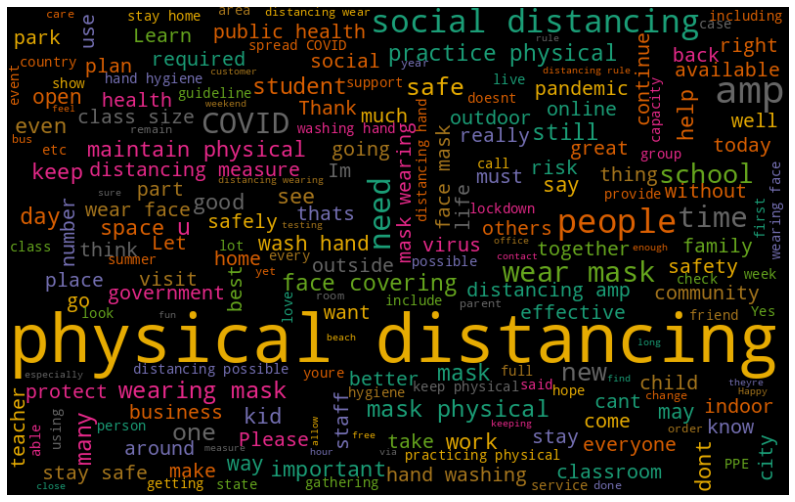

In [58]:
all_words = ' '.join([text for text in tweets_df['absolute_tidy_tweets'][tweets_df.sentiment == 'positive']])
generate_wordcloud(all_words)

In [61]:
# function to collect hashtags
def hashtag_extract(text_list):
    hashtags = []
    # Loop over the words in the tweet
    for text in text_list:
        ht = re.findall(r"#(\w+)", text)
        hashtags.append(ht)

    return hashtags

def generate_hashtag_freqdist(hashtags):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 15 most frequent hashtags     
    d = d.nlargest(columns="Count", n = 25)
    plt.figure(figsize=(16,7))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    plt.xticks(rotation=80)
    ax.set(ylabel = 'Count')
    plt.show()

In [62]:
hashtags = hashtag_extract(tweets_df['tidy_tweets'])
hashtags = sum(hashtags, [])

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3650 (\N{THAI CHARACTER SARA O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3588 (\N{THAI CHARACTER KHO KHWAI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


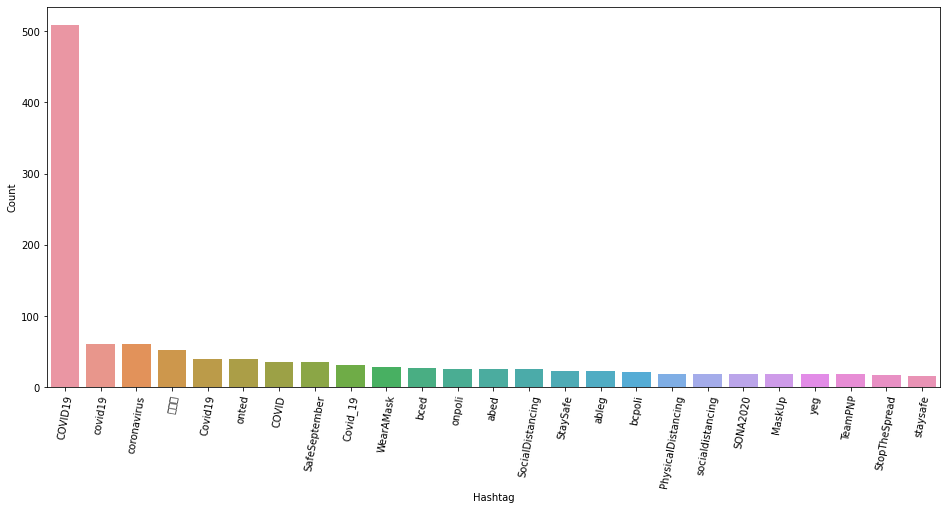

In [63]:
generate_hashtag_freqdist(hashtags)

In [65]:
tweets_df2 = tweets_df[tweets_df['key_phrases'].str.len()>0]

## Naive-Bayes Model for Sentiment Analysis

In [67]:
tweets_df.columns

Index(['Datetime', 'Tweet Id', 'Text', 'sentiment', 'tidy_tweets',
       'absolute_tidy_tweets', 'key_phrases'],
      dtype='object')

In [83]:
features = tweets_df.drop(['Datetime', 'Tweet Id', 'Text', 'sentiment', 'tidy_tweets', 'key_phrases'], axis=1)
labels = tweets_df['sentiment']

In [95]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.20, random_state=42)

print("Data distribution:\n- Train: {} \n- Test: {}".format(len(y_train),len(y_test)))

Data distribution:
- Train: 7510 
- Test: 1878


In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(data,tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

In [97]:
tfidf_vect = TfidfVectorizer(analyzer=clean)
tfidf_vect_fit=tfidf_vect.fit(X_train['absolute_tidy_tweets'])
X_train=vectorize(X_train['absolute_tidy_tweets'],tfidf_vect_fit)
X_test=vectorize(X_test['absolute_tidy_tweets'],tfidf_vect_fit)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators = 7)
scores = cross_val_score(rf,X_train,y_train.values.ravel(),cv=7)

In [99]:
print(scores)
print("Cross Validation Score:", scores.mean())

[0.65517241 0.69151911 0.67753961 0.67101584 0.64958062 0.65890028
 0.66697761]
Cross Validation Score: 0.6672436396767328


In [102]:
from sklearn.metrics import accuracy_score,precision_score,recall_score, classification_report

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy = round(accuracy_score(y_test,y_pred), 3)
precision = round(precision_score(y_test,y_pred, average='micro'), 3)
recall = round(recall_score(y_test,y_pred, average='micro'), 3)

In [103]:
print("Accuracy:, ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

Accuracy:,  0.667
Precision:  0.667
Recall:  0.667


In [105]:
print("CLassification Report:\n", classification_report(y_test,y_pred))

CLassification Report:
               precision    recall  f1-score   support

    negative       0.59      0.32      0.41       402
     neutral       0.59      0.59      0.59       427
    positive       0.71      0.83      0.76      1049

    accuracy                           0.67      1878
   macro avg       0.63      0.58      0.59      1878
weighted avg       0.66      0.67      0.65      1878

